In [35]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.autograd import Variable
from torch.distributions.kl import kl_divergence
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.utils import save_image

writer = SummaryWriter("mnist_experiment_1")

In [88]:
bs = 16
# MNIST Dataset
train_dataset = datasets.MNIST(
    root="data", train=True, download=True, transform=ToTensor()
)

test_dataset = datasets.MNIST(
    root="data", train=False, download=True, transform=ToTensor()
)
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=bs, shuffle=True
)
validation_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=bs, shuffle=False
)

In [89]:
class VAE(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: list, z_dim):
        super(VAE, self).__init__()

        self.z_dim = z_dim

        self.encoder_layers = nn.ModuleList([nn.Linear(input_dim, hidden_dim[0])])
        self.decoder_layers = nn.ModuleList([nn.Linear(hidden_dim[0], input_dim)])

        if len(hidden_dim) > 1:
            for i in range(len(hidden_dim) - 1):
                self.encoder_layers.append(nn.Linear(hidden_dim[i], hidden_dim[i + 1]))
                self.decoder_layers.insert(
                    0, nn.Linear(hidden_dim[i + 1], hidden_dim[i])
                )

        self.encoder_layers.append(nn.Linear(hidden_dim[-1], 2 * z_dim))
        self.decoder_layers.insert(0, nn.Linear(z_dim, hidden_dim[-1]))

    def encoder(self, x):
        for idx, layer in enumerate(self.encoder_layers):
            x = layer(x)
            if idx < len(self.encoder_layers) - 1:
                # x = F.dropout(x, 0.01)
                x = F.relu(x)
        return x[..., : self.z_dim], x[..., self.z_dim :]  # mu, log_var

    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        # std = torch.abs(log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)  # return z sample

    def decoder(self, z):
        for idx, layer in enumerate(self.decoder_layers):
            z = layer(z)
            if idx < len(self.decoder_layers) - 1:
                # x = F.dropout(x, 0.01)
                z = F.relu(z)
        return torch.sigmoid(z)

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))

        #    z = self.sampling(mu, log_var)
        latent = MultivariateNormal(
            loc=mu, scale_tril=torch.diag_embed(torch.exp(0.5 * log_var))
        )
        z = latent.rsample()

        #    return self.decoder(z), mu, log_var
        return self.decoder(z), latent, z

    @staticmethod
    def loss_function(recon_x, x, mu, log_var):
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return BCE + KLD

    @staticmethod
    def loss_function_dist(recon_x, x, latent):
        prior = MultivariateNormal(
            loc=torch.zeros(latent.mean.shape[1]),
            scale_tril=torch.eye(latent.mean.shape[1]),
        )

        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
        KLD = torch.sum(kl_divergence(latent, prior))
        return BCE + KLD

In [90]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.0
    last_loss = 0.0

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, (data, _) in enumerate(train_loader):
        # Every data instance
        data = data.to(DEVICE)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        recon_batch, latent, z = vae(data)

        # Compute the loss and its gradients
        loss = VAE.loss_function_dist(recon_batch, data, latent)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000  # loss per batch
            print("  batch {} loss: {}".format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar("Loss/train", last_loss, tb_x)
            running_loss = 0.0

    return last_loss

In [91]:
# build model

vae = VAE(input_dim=784, hidden_dim=[512, 256], z_dim=32)
# if torch.backends.mps.is_available():
#     DEVICE = 'mps'
# else:
# train_loader = torch.utils.data.DataLoader(dataset=torch.Tensor(torch.randn(30, 5000)), batch_size=100, shuffle=True)

DEVICE = "cpu"

vae.to(DEVICE)

optimizer = optim.Adam(vae.parameters())


# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter("runs/tcga_trainer_{}".format(timestamp))
epoch_number = 0

EPOCHS = 20

best_vloss = 1_000_000.0

for epoch in range(EPOCHS):
    print("EPOCH {}:".format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    vae.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    vae.train(False)

    running_vloss = 0.0
    for i, (vdata, _) in enumerate(validation_loader):
        vinputs = vdata
        voutputs, latent, z = vae(vinputs)

        vloss = VAE.loss_function_dist(voutputs, vinputs, latent)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)

    print("LOSS train {} valid {}".format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars(
        "Training vs. Validation Loss",
        {"Training": avg_loss, "Validation": avg_vloss},
        epoch_number + 1,
    )
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = "model_{}_{}".format(timestamp, epoch_number)
        # torch.save(vae.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 2788.403889526367
  batch 2000 loss: 2184.14864855957
  batch 3000 loss: 2031.7818149414063
LOSS train 2031.7818149414063 valid 1927.2020263671875
EPOCH 2:
  batch 1000 loss: 1906.9812685546874
  batch 2000 loss: 1881.320148803711
  batch 3000 loss: 1859.2270234375
LOSS train 1859.2270234375 valid 1815.9661865234375
EPOCH 3:
  batch 1000 loss: 1818.3405036621093
  batch 2000 loss: 1799.6561943359375
  batch 3000 loss: 1783.8739400634765
LOSS train 1783.8739400634765 valid 1761.2161865234375
EPOCH 4:
  batch 1000 loss: 1754.6400571289062
  batch 2000 loss: 1759.922014526367
  batch 3000 loss: 1754.0397690429688
LOSS train 1754.0397690429688 valid 1733.652587890625
EPOCH 5:
  batch 1000 loss: 1728.2391251220704
  batch 2000 loss: 1730.6410325927734
  batch 3000 loss: 1726.6325330810546
LOSS train 1726.6325330810546 valid 1716.995361328125
EPOCH 6:
  batch 1000 loss: 1709.537234008789
  batch 2000 loss: 1718.4894558105468
  batch 3000 loss: 1705.1193331298828
L

In [92]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

In [93]:
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=50,
        shuffle=True)

Permute some pixals of an image

Effect of adding noise on reconstruction loss metrices

In [94]:
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + "(mean={0}, std={1})".format(
            self.mean, self.std
        )

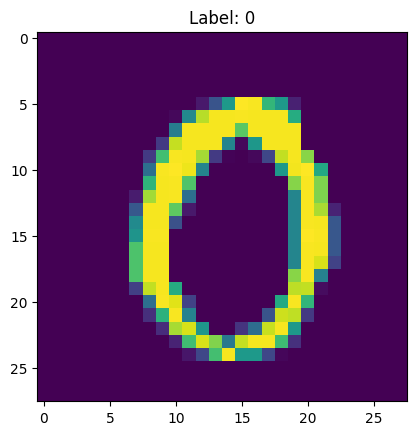

<Figure size 640x480 with 0 Axes>

In [95]:
image, label = test_dataset[13]
image = image.squeeze(0)  # Remove the channel dimension

# Plot the image
plt.imshow(image)
plt.title(f"Label: {label}")
plt.show()
plt.savefig("original0.png")

In [96]:
test_dataset_noisy_0p1 = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.0,), (1.0,)),
            AddGaussianNoise(0.0, 0.1),
        ]
    ),
)

test_dataset_noisy_0p3 = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.0,), (1.0,)),
            AddGaussianNoise(0.0, 0.3),
        ]
    ),
)

test_dataset_noisy_0p5 = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.0,), (1.0,)),
            AddGaussianNoise(0.0, 0.5),
        ]
    ),
)

test_dataset_noisy_0p6 = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.0,), (1.0,)),
            AddGaussianNoise(0.0, 0.60),
        ]
    ),
)

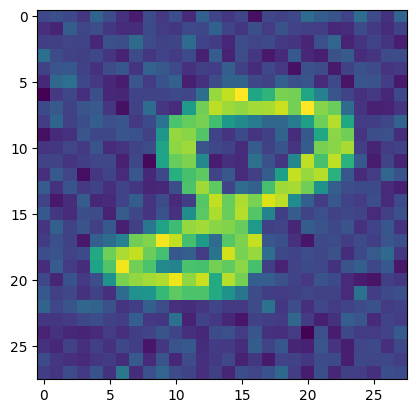

In [97]:
for image, label in test_dataset_noisy_0p1:
    img = image
    lb = label
    if label == 8:
        break

#image, label = test_dataset_noisy_0p6[13]
image = img.squeeze(0)  # Remove the channel dimension
image.data
# Plot the image
plt.imshow(image)
# plt.title(f'Label: {label}')


In [98]:
import numpy as np
def calculate_snr(image):
    # Calculate the mean signal and standard deviation of the noise
    signal = np.mean(image)
    noise = np.std(image)

    # Calculate the SNR
    snr = signal / noise

    return snr

In [99]:
calculate_snr(np.array(image))

0.4499705

In [100]:
recon_test_noisy, latent_test_noisy, z = vae(image)

In [101]:
calculate_snr(np.array(recon_test_noisy.detach().view(1, 28, 28).permute(1, 2, 0)))

0.5615548

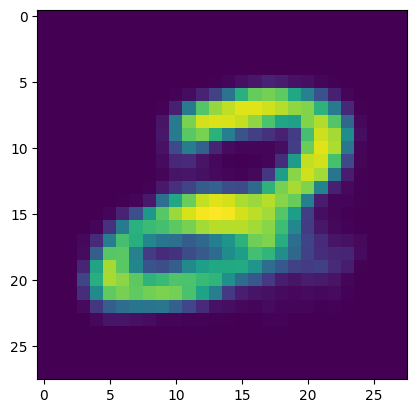

In [102]:
plt.imshow(recon_test_noisy.detach().view(1, 28, 28).permute(1, 2, 0))
#plt.savefig("reconstructed_noisy0.png")

In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define the transform to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='data/', train=False, transform=transform, download=True)

# Create data loaders for the training and testing sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load the pre-trained VAE model and extract its encoder

# Define the classifier architecture
class Classifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.log_softmax(self.fc3(x), dim=1)
        return x

# Create an instance of the classifier
classifier = Classifier(input_dim=32, output_dim=10)

# Define the loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

# Train the classifier using the pre-trained VAE embeddings
for epoch in range(10):
    running_loss = 0.0
    for i, (x, y) in enumerate(train_loader):
        with torch.no_grad():
            _, _, z = vae(x)
        y_pred = classifier(z)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch + 1} loss: {epoch_loss:.4f}")

# Evaluate the classifier on the test set
correct = 0
total = 0
with torch.no_grad():
    for x, y in test_loader:
        _, _, z = vae(x)
        y_pred = classifier(z).argmax(dim=1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()
accuracy = correct / total
print(f"Test accuracy: {accuracy:.4f}")


Epoch 1 loss: 0.4919
Epoch 2 loss: 0.3191
Epoch 3 loss: 0.2904
Epoch 4 loss: 0.2605
Epoch 5 loss: 0.2467
Epoch 6 loss: 0.2383
Epoch 7 loss: 0.2263
Epoch 8 loss: 0.2217
Epoch 9 loss: 0.2151
Epoch 10 loss: 0.2136
Test accuracy: 0.9342


In [111]:
test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.0,), (1.0,)),
            AddGaussianNoise(0.0, 0.00001),
        ]
    ),
)

In [112]:
# Evaluate the classifier on the test set
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for x, y in test_loader:
        _, _, z = vae(x)
        y_pred = classifier(z).argmax(dim=1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()
accuracy = correct / total
print(f"Test accuracy: {accuracy:.4f}")


Test accuracy: 0.2160


In [113]:
# Evaluate the classifier on the test set
test_loader_noisy_0p1 = DataLoader(test_dataset_noisy_0p1, batch_size=50, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for x, y in test_loader_noisy_0p1:
        _, _, z = vae(x)
        y_pred = classifier(z).argmax(dim=1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()
accuracy = correct / total
print(f"Test accuracy: {accuracy:.4f}")


Test accuracy: 0.2192


In [114]:
# Evaluate the classifier on the test set
test_loader_noisy_0p3 = DataLoader(test_dataset_noisy_0p3, batch_size=50, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for x, y in test_loader_noisy_0p3:
        _, _, z = vae(x)
        y_pred = classifier(z).argmax(dim=1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()
accuracy = correct / total
print(f"Test accuracy: {accuracy:.4f}")


Test accuracy: 0.2179


In [115]:
# Evaluate the classifier on the test set
test_loader_noisy_0p5 = DataLoader(test_dataset_noisy_0p5, batch_size=16, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for x, y in test_loader_noisy_0p5:
        _, _, z = vae(x)
        y_pred = classifier(z).argmax(dim=1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()
accuracy = correct / total
print(f"Test accuracy: {accuracy:.4f}")


Test accuracy: 0.2262


In [110]:
# Evaluate the classifier on the test set
test_loader_noisy_0p6 = DataLoader(test_dataset_noisy_0p6, batch_size=50, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for x, y in test_loader_noisy_0p6:
        _, _, z = vae(x)
        y_pred = classifier(z).argmax(dim=1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()
accuracy = correct / total
print(f"Test accuracy: {accuracy:.4f}")


Test accuracy: 0.2195


In [62]:
test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.0,), (1.0,)),
            AddGaussianNoise(0.0, 0.00001),
        ]
    ),
)

In [63]:
snr=[]
snr_op1=[]
snr_op3=[]
snr_op5=[]
snr_op6=[]

for image, label in test_dataset:
    snr.append(calculate_snr(np.array(image)))

for image, label in test_dataset_noisy_0p1:
    snr_op1.append(calculate_snr(np.array(image)))
    
for image, label in test_dataset_noisy_0p3:
    snr_op3.append(calculate_snr(np.array(image)))

for image, label in test_dataset_noisy_0p5:
    snr_op5.append(calculate_snr(np.array(image)))

for image, label in test_dataset_noisy_0p6:
    snr_op6.append(calculate_snr(np.array(image)))


In [64]:
print(np.mean(snr))
print(np.mean(snr_op1))
print(np.mean(snr_op3))
print(np.mean(snr_op5))
print(np.mean(snr_op6))

0.42458585
0.40327758
0.3035395
0.22342193
0.19547324


In [65]:
SNRs = [np.mean(snr), np.mean(snr_op1), np.mean(snr_op3), np.mean(snr_op5), np.mean(snr_op6)]

In [66]:
SNRs

[0.42458585, 0.40327758, 0.3035395, 0.22342193, 0.19547324]

In [67]:
batch_50_z_128_acc =[0.2897, 0.2875, 0.2935,  0.3207, 0.3236] #overfits
batch_50_z_64_acc =[0.2709, 0.2597, 0.2836,  0.2971, 0.3209] #overfits
batch_50_z_32_acc =[0.2875, 0.2933, 0.3041,  0.3283, 0.3425] #overfits

In [68]:
batch_32_z_100_acc =[0.1889, 0.1908, 0.1965,  0.2085, 0.2081] #no overfits
batch_32_z_64_acc =[0.1362, 0.1356, 0.1453,  0.1565, 0.1622] #no overfits
batch_16_z_32_acc =[0.1362, 0.1356, 0.1453,  0.1565, 0.1622] #no overfits

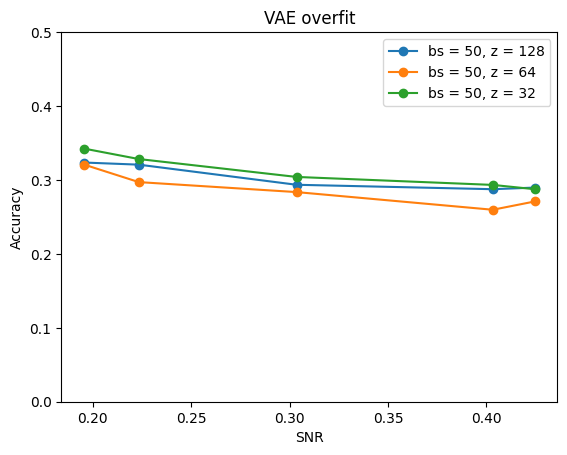

In [85]:
plt.title("VAE overfit")
plt.plot(SNRs, batch_50_z_128_acc, "-o",label="bs = 50, z = 128")
plt.plot(SNRs, batch_50_z_64_acc, "-o", label="bs = 50, z = 64")
plt.plot(SNRs, batch_50_z_32_acc, "-o", label="bs = 50, z = 32")
plt.ylim(0,0.5)
plt.xlabel("SNR")
plt.ylabel("Accuracy")
plt.legend()

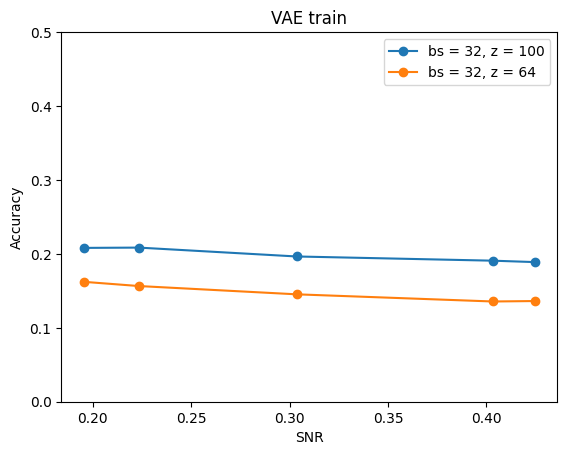

In [87]:
plt.title("VAE train")
plt.plot(SNRs, batch_32_z_100_acc, "-o", label="bs = 32, z = 100")
plt.plot(SNRs, batch_32_z_64_acc, "-o", label="bs = 32, z = 64")
plt.ylim(0,0.5)
plt.xlabel("SNR")
plt.ylabel("Accuracy")
plt.legend()